In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import thinkstats2
from scipy.stats import ks_2samp

data_at = pd.read_csv('../data/A_train.csv')
data_bt = pd.read_csv('../data/B_train.csv')
data_test = pd.read_csv('../data/B_test.csv')

* 维度情况
    * 3组数据维度一样，维度之间可比较？

In [8]:
print data_bt.columns.shape
print data_bt.columns.intersection(data_at.columns).shape
print data_bt.columns.intersection(data_test.columns).shape

(491L,)
(491L,)
(490L,)


* 连续与离散
    * 知识：https://blog.csdn.net/ztf312/article/details/53991329 https://blog.csdn.net/banbuduoyujian/article/details/53957653
    * https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.cut.html
    * 预计489维数据中，383维的取值在100个以内，推测大部分应该是离散值
    * 取值在100个以上的可能为连续值
    * 取值大于300的维度81个，大于500的69个，这些极可能是连续值
    * 需要对连续值进行离散化：分类

In [ ]:
discrete_threshold = 120
data_tmp_all = pd.concat([data_at.sort_index(axis=1).drop(['flag','no'],axis=1),data_bt.sort_index(axis=1).drop(['flag','no'],axis=1)])
data_tmp_all = pd.concat([data_tmp_all, data_test.sort_index(axis=1).drop(['no'],axis=1)])
data_all_n_unique = data_tmp_all.nunique()
#plt.hist(data_all_n_unique, cumulative=False, bins=100)
#plt.show()
discrete_columns = data_all_n_unique[data_all_n_unique<=discrete_threshold].index
continuous_columns = data_all_n_unique[data_all_n_unique>discrete_threshold].index
null_columns_all = np.sum(data_tmp_all.isnull(), axis=0).sort_values(ascending=True)


* 缺失值分析
    * https://blog.csdn.net/weixin_40159138/article/details/89421014
    * https://www.jianshu.com/p/9c867fb9cf17
    * https://scikit-learn.org/stable/modules/impute.html#impute
    * 从下图可以看到缺失值非常接近
    * B_test和A_train缺失值情况几乎一致
    * B_train的缺失值情况比A_train严重很多
    * A_train中20%的用户缺失维度在100个以内，40%的缺失维度在450个以上，60%用户的缺失维度在150个以内
    * B_train 和 B_test 38%的用户缺失维度在186左右，60%用户维度缺失在460以上
    * 缺失值在学习过程中，feature_importance 会降低，并不一定会影响学习效果

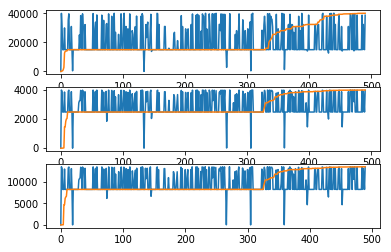

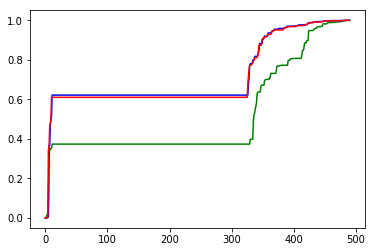

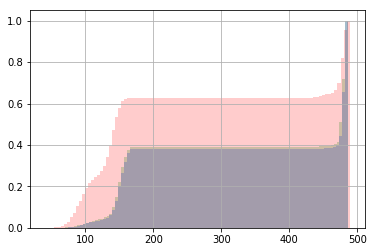

用户的维度缺失情况
0.602675
0.37875
0.38980910643987227


In [9]:
fea_null = np.sum(data_at.isnull(), axis=0)
feb_null = np.sum(data_bt.isnull(), axis=0)
fet_null = np.sum(data_test.isnull(), axis=0)

plt.subplot(311).plot(fea_null.values)
plt.subplot(312).plot(feb_null.values)
plt.subplot(313).plot(fet_null.values)

# sort_values
plt.subplot(311).plot(np.sort(fea_null))
plt.subplot(312).plot(np.sort(feb_null))
plt.subplot(313).plot(np.sort(fet_null))
plt.show()

# 缺失值占所有值的比例
plt.plot(np.sort(fea_null/data_at.shape[0]), color='green')
plt.plot(np.sort(feb_null/data_bt.shape[0]), color='blue')
plt.plot(np.sort(fet_null/data_test.shape[0]),color='red')
plt.show()

u_fea_null = np.sum(data_at.isnull(), axis=1)
u_feb_null = np.sum(data_bt.isnull(), axis=1)
u_fet_null = np.sum(data_test.isnull(), axis=1)
u_fea_null.hist(cumulative=True, density=1, bins=100, alpha=.2, color="r")
u_feb_null.hist(cumulative=True, density=1, bins=100, alpha=.2, color="b")
u_fet_null.hist(cumulative=True, density=1, bins=100, alpha=.2, color="g")
plt.show()
print "用户的维度缺失情况"
print (u_fea_null[u_fea_null<156].count()-0.0)/u_fea_null.count()
print (u_feb_null[u_feb_null<186].count()-0.0)/u_feb_null.count()
print (u_fet_null[u_fet_null<186].count()-0.0)/u_fet_null.count()


* 异常值分析
    * https://www.cnblogs.com/tinglele527/p/11955103.html
    * 离散值中取值比例很小的这部分，可能有两种情况：对预测结果有强作用，对预测情况无影响
    * 连续值中，box plot可以很方便观测处异常值

In [ ]:
#标准差法 sunspots.counts > xbar + 2 * xstd
big_variance_columns = {}
for column in continuous_columns:
    mean = data_at[column].mean()
    std = data_at[column].std()
    tmp = any(data_at[column]>mean+2*std)


* 同分布检验
    * https://blog.csdn.net/qq_41679006/article/details/80977113
    * https://www.cnblogs.com/arkenstone/p/5496761.html
    * https://blog.csdn.net/t15600624671/article/details/78770239
    * B_test 和 B_train只有2维数据的分布差异较大，显著性α=0.05
    * B_train 和 A_train的数据差异较大：有199维数据的分布相差大，所以考虑剔除掉199维数据
    * 缺失值少，且同分布的维度 极有可能是最重要的维度，可以尝试只取这部分数据进行分析

In [ ]:
dis_b_diff = {};dis_b_same={};dis_ab_diff={};dis_ab_same={}
for column in data_bt.columns.drop(['no','flag']):
    print column
    d, p = ks_2samp(data_bt[column].dropna(), data_test[column].dropna())
    if p<=0.05:
        dis_b_diff[column] = (d,p)
    else:
        dis_b_same[column] = (d,p)
    d, p = ks_2samp(data_bt[column].dropna(), data_at[column].dropna())
    if p<=0.05:
        dis_ab_diff[column] = (d,p)
    else:
        dis_ab_same[column] = (d,p)
dis_b_diff = pd.DataFrame.from_dict(dis_b_diff,orient='index')
dis_b_same = pd.DataFrame.from_dict(dis_b_same,orient='index')
dis_ab_diff = pd.DataFrame.from_dict(dis_ab_diff,orient='index')
dis_ab_same = pd.DataFrame.from_dict(dis_ab_same,orient='index')
# 缺失值少，且同分布的维度
null_num = 300
same_features = feb_null.sort_values(ascending=False).tail(null_num).index.intersection(dis_ab_same.index)
same_features = same_features.intersection(fea_null.sort_values(ascending=False).tail(null_num).index)